# ctdproc: Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import ctdproc as ctd

plt.ion()

%config InlineBackend.figure_format = 'retina'

xr.set_options(display_style="text");

In [2]:
pd.options.display.html.table_schema = True

Path to example CTD file in .hex format. The corresponding xmlcon file needs to be in the same directory.

In [3]:
hexfile = Path('../ctdproc/tests/data/BLT_Test_001.hex')

Convert hex file

In [4]:
c = ctd.io.CTDHex(hexfile)

Display parameters as read from xmlcon file. The parameters come in a `pandas.DataFrame`.

In [5]:
c.cfgp.transpose()

,@index,@SensorID,cal
TemperatureSensor1,0,55,"{'@SensorID': '55', 'SerialNumber': '2322', 'C..."
ConductivitySensor1,1,3,"{'@SensorID': '3', 'SerialNumber': '2569', 'Ca..."
PressureSensor,2,45,"{'@SensorID': '45', 'SerialNumber': '1316', 'C..."
TemperatureSensor2,3,55,"{'@SensorID': '55', 'SerialNumber': '6142', 'C..."
ConductivitySensor2,4,3,"{'@SensorID': '3', 'SerialNumber': '3207', 'Ca..."
FluoroSeapointSensor,5,11,"{'@SensorID': '11', 'SerialNumber': 'SCF2956',..."
PAR_BiosphericalLicorChelseaSensor,6,42,"{'@SensorID': '42', 'SerialNumber': '4542', 'C..."
WET_LabsCStar,7,71,"{'@SensorID': '71', 'SerialNumber': 'CST-1874D..."
AltimeterSensor,9,0,"{'@SensorID': '0', 'SerialNumber': 'N/A', 'Cal..."
OxygenSensor,11,38,"{'@SensorID': '38', 'SerialNumber': '0255', 'C..."


Convert the data to an `xarray.Dataset`.

In [6]:
cx = c.to_xarray()

Display the Dataset.

In [7]:
cx

<xarray.Dataset>
Dimensions:   (time: 120643)
Coordinates:
  * time      (time) datetime64[ns] 2019-11-06T18:20:31.000002 ... 2019-11-06...
Data variables:
    lon       (time) float64 -117.5 -117.5 -117.5 ... -117.5 -117.5 -117.5
    lat       (time) float64 32.62 32.62 32.62 32.62 ... 32.62 32.62 32.62 32.62
    p         (time) float64 2.121 2.156 2.184 2.127 ... 1.601 1.572 1.551 1.551
    t1        (time) float64 17.76 17.79 17.83 17.88 ... 18.49 18.48 18.47 18.46
    t2        (time) float64 17.96 17.95 17.95 17.94 ... 18.5 18.51 18.52 18.52
    c1        (time) float64 4.406 4.41 4.415 4.421 ... 4.478 4.477 4.475 4.475
    c2        (time) float64 4.421 4.422 4.421 4.42 ... 4.481 4.482 4.482 4.482
    alt       (time) float64 74.73 74.73 74.73 74.73 ... 74.58 74.58 74.58 74.58
    fl        (time) float64 0.1062 0.1074 0.1074 ... 0.0293 0.0293 0.03053
    trans     (time) float64 92.04 92.04 92.04 92.04 ... 96.79 96.79 96.79 96.79
    par       (time) float64 1.175e+03 1.178e+03 ... 4.531e+03 4.531e+03
    modcount  (time) int64 63 64 65 66 67 68 69 ... 123 124 125 126 127 128 129

Save time series to netcdf.

In [8]:
cx.to_netcdf('test.nc')

Save time series as Matlab file.

In [9]:
c.to_mat('./test.mat')

Plot time series from temperature sensor 1

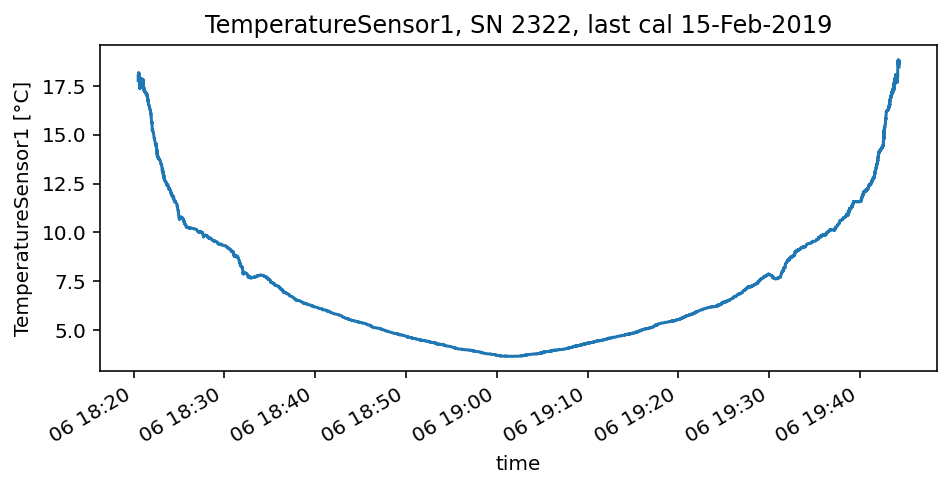

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 3))
cx.t1.plot(ax=ax)
ax.set(
    title="{}, SN {}, last cal {}".format(
        cx.t1.attrs["long_name"], cx.t1.attrs["SN"], cx.t1.attrs["CalDate"]
    )
);

Plot more time series. Adjust automatic axis labels to fit everything.

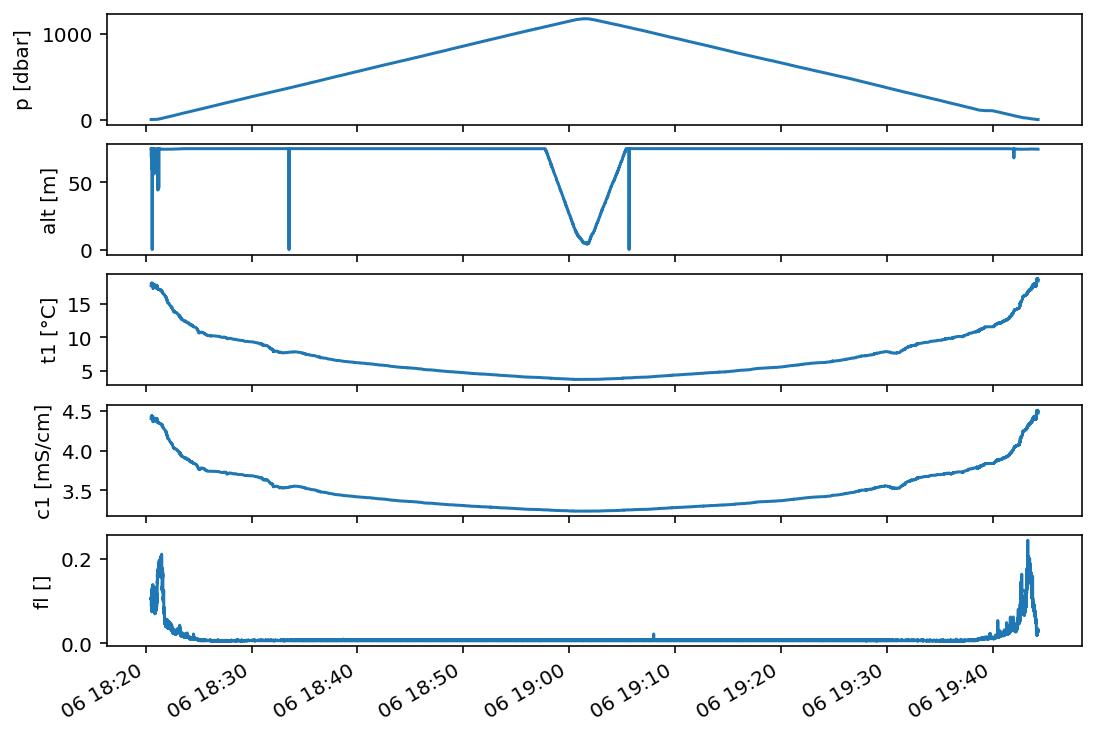

In [11]:
plot_vars = ["p", "alt", "t1", "c1", "fl"]
fig, ax = plt.subplots(
    nrows=len(plot_vars),
    ncols=1,
    figsize=(7.5, 5),
    constrained_layout=True,
    sharex=True,
)
for axi, vi in zip(ax, plot_vars):

    cx[vi].plot(ax=axi)
    axi.set(ylabel="{:s} [{:s}]".format(vi, cx[vi].attrs["units"]), xlabel="")

Plot location data.

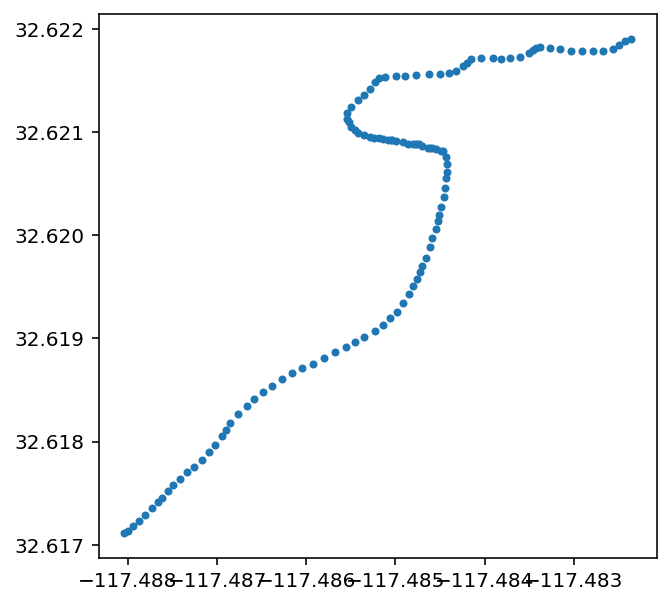

In [12]:
cxc = cx.coarsen(time=1000, boundary='trim').mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.plot(cxc.lon, cxc.lat, marker='.', linestyle='');

Run further processing steps on the time series.

In [13]:
ctd.io.add_default_proc_params(cx)

In [14]:
cx_ud = ctd.proc.run_all(cx)

1: tau = 0.0501s, lag = -0.0044s
2: tau = 0.0720s, lag = -0.0079s
1: tau = 0.0502s, lag = -0.0048s
2: tau = 0.0756s, lag = -0.0080s


/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(


Depth binning.

In [15]:
dz = 1
zmin = 10
zmax = np.ceil(cx_ud['down'].depth.max().data)
datad = ctd.proc.bincast(cx_ud['down'], dz, zmin, zmax)
datau = ctd.proc.bincast(cx_ud['up'], dz, zmin, zmax)

Final data structure.

In [16]:
datad

<xarray.Dataset>
Dimensions:  (depth: 1156)
Coordinates:
  * depth    (depth) float64 10.0 11.0 12.0 ... 1.163e+03 1.164e+03 1.165e+03
    lon      (depth) float64 -117.5 -117.5 -117.5 -117.5 ... -117.5 -117.5 nan
    lat      (depth) float64 32.62 32.62 32.62 32.62 ... 32.62 32.62 32.62 nan
    time     (depth) datetime64[ns] 2019-11-06T18:21:21.062499887 ... NaT
Data variables: (12/19)
    t1       (depth) float64 17.13 17.1 17.09 17.03 ... 3.676 3.674 3.673 nan
    t2       (depth) float64 17.13 17.1 17.09 17.04 ... 3.677 3.676 3.675 nan
    c1       (depth) float64 4.343 4.341 4.339 4.334 ... 3.237 3.237 3.237 nan
    c2       (depth) float64 4.344 4.341 4.34 4.335 ... 3.238 3.237 3.237 nan
    p        (depth) float64 10.07 11.08 12.09 13.09 ... 1.175e+03 1.176e+03 nan
    trans    (depth) float64 89.54 89.91 90.47 90.86 ... 102.1 102.1 102.1 nan
    ...       ...
    CT1      (depth) float64 17.15 17.13 17.12 17.06 ... 3.59 3.588 3.588 nan
    CT2      (depth) float64 17.16 17.13 17.12 17.07 ... 3.591 3.59 3.589 nan
    th1      (depth) float64 17.12 17.1 17.08 17.03 ... 3.588 3.586 3.586 nan
    th2      (depth) float64 17.13 17.1 17.09 17.03 ... 3.59 3.588 3.587 nan
    sg1      (depth) float64 24.43 24.43 24.43 24.45 ... 27.45 27.45 27.45 nan
    sg2      (depth) float64 24.43 24.43 24.44 24.45 ... 27.45 27.45 27.45 nan
Attributes: (12/19)
    verbose:         1
    bounds_p:        [0.0, 6200.0]
    bounds_t:        [-2.0, 40.0]
    bounds_c:        [2.5, 6.0]
    bounds_s:        [20, 38]
    spike_thresh_t:  0.5
    ...              ...
    diff_s:          0.001
    diff_p:          2.0
    wthresh:         0.1
    plot_spectra:    0
    plot_path:       
    tcfit:           [500, array(1177.70166413)]

Plot potential density anomaly profile and its difference between the two sensors.

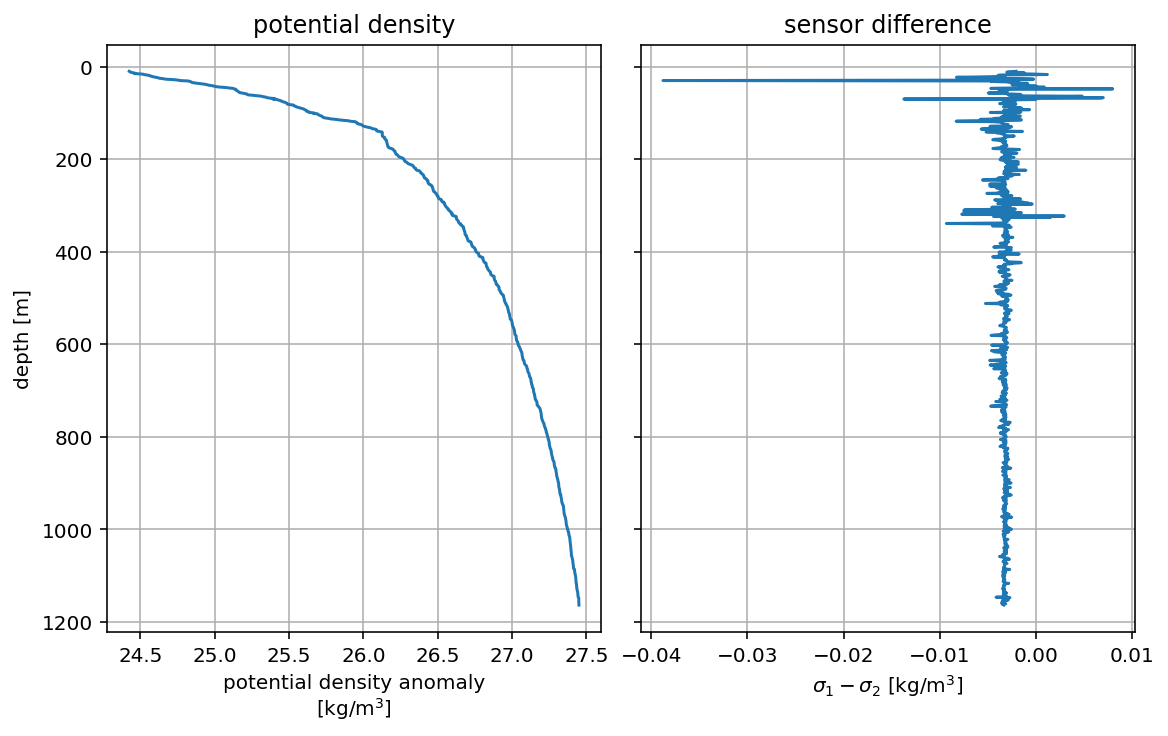

In [17]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 5), constrained_layout=True, sharey=True
)
datad.sg1.plot(y="depth", yincrease=False, ax=ax[0])
ax[0].set(title="potential density")
(datad.sg1 - datad.sg2).plot(y="depth", yincrease=False, ax=ax[1])
ax[1].set(title="sensor difference", ylabel="", xlabel="$\sigma_1-\sigma_2$ [kg/m$^3$]")
for axi in ax:
    axi.grid(True)